In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
import gymnasium as gym
import numpy as np
from envs.dubins_car import DubinsCarEnv


import jax
import jax.numpy as jnp
import haiku as hk
import optax

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
jax.default_backend()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


'cpu'

In [24]:
#generate data

x_s = np.linspace(-4,4, 20)
y_s = np.linspace(-4,4, 20)
theta_s = np.linspace(0,2*np.pi, 15)

xx, yy, tt = np.meshgrid(x_s, y_s, theta_s)
grid = np.vstack([xx.ravel(), yy.ravel(), tt.ravel()]).T



env = DubinsCarEnv()
state = env.reset()
X = []
y = []
for i in range(len(grid)):
    state = env.set(grid[i][0], grid[i][1], grid[i][2])
    X.append(state)

X_grid = np.array(X)
y_grid = np.array(y)
len(X_grid)


6000

In [25]:
X_grid

array([[-4.        , -4.        ,  0.        ],
       [-4.        , -4.        ,  0.44879895],
       [-4.        , -4.        ,  0.8975979 ],
       ...,
       [ 4.        ,  4.        ,  5.38558741],
       [ 4.        ,  4.        ,  5.83438636],
       [ 4.        ,  4.        ,  6.28318531]])

In [26]:


def uniform_samples(env, n):

    state = env.reset()
    X_rand = []
    for i in range(n):
        state = env.reset()
        X_rand.append(state)
        for action in range(env.action_space.n):
            next_state, reward, done, info = env.step(state, action, update_env=False)
            if info['is_legal']:
                X_rand.append(next_state)
    return np.array(X_rand)


X_samp = uniform_samples(env, 100)
X_val = uniform_samples(env,2000)


In [27]:
X = np.vstack([X_grid])
#np.random.shuffle(X)
#X = np.flip(X,0)
len(X)

6000

In [28]:
def filter(X, get_y=None):
    filted_X = []
    for x in X:
        # calculate distance to goal and obstacle
        dist_obstacle = np.linalg.norm(x[:2] - env.obstacle_position) - env.obstacle_radius
        if dist_obstacle > 0: 

            filted_X.append(x)
    return np.array(filted_X)

X = filter(X)

In [29]:
ys = [env.get_reward(x) for x in X]
    
ys = np.array(ys)

In [30]:
max(ys)

1

In [31]:
def plot_surface(X_in,env, file_name=None, y_pred=None, ys=None):
    %matplotlib inline

    plt.rcParams['figure.figsize'] = [15, 12]

    # Plot...
    plt.scatter(X_in[:,0], X_in[:,1], s=1) # s is a size of marker 
    plt.colorbar(label='estimated value')
    goal = plt.Circle((env.goal_position[0], env.goal_position[1]), env.min_distance_to_goal, color='g', fill=False)

    # draw obstacle
    obstacle = plt.Circle((env.obstacle_position[0], env.obstacle_position[1]), env.obstacle_radius, color='r', fill=False)
    plt.gca().add_artist(obstacle)
    plt.gca().add_artist(goal)


    arrow_len = env.v_max
    # Calculate arrow components
    arrow_dx = arrow_len * np.cos(X_in[:,2])
    arrow_dy = arrow_len * np.sin(X_in[:,2])

    if y_pred:
        arrow_colors = cm.jet((y_pred-np.min(y_pred))/(np.max(y_pred)-np.min(y_pred)))
    elif len(ys)>0:
        arrow_colors = cm.get_cmap('jet', 3)(ys+1)

    else:
        arrow_colors = 'k'


    plt.quiver(X_in[:,0], X_in[:,1], arrow_dx, arrow_dy, angles='xy', scale_units='xy', scale=1, width=0.002, color=arrow_colors)


    #plt.jet()
    #plt.show()
    if file_name:
        plt.savefig(file_name)
    #plt.show()


In [32]:
len(X)

5940

In [33]:
env.step(np.array([-2,2,np.pi]),1)

(array([-2.25      ,  2.        ,  3.14159265]), 0, False, {'is_legal': True})

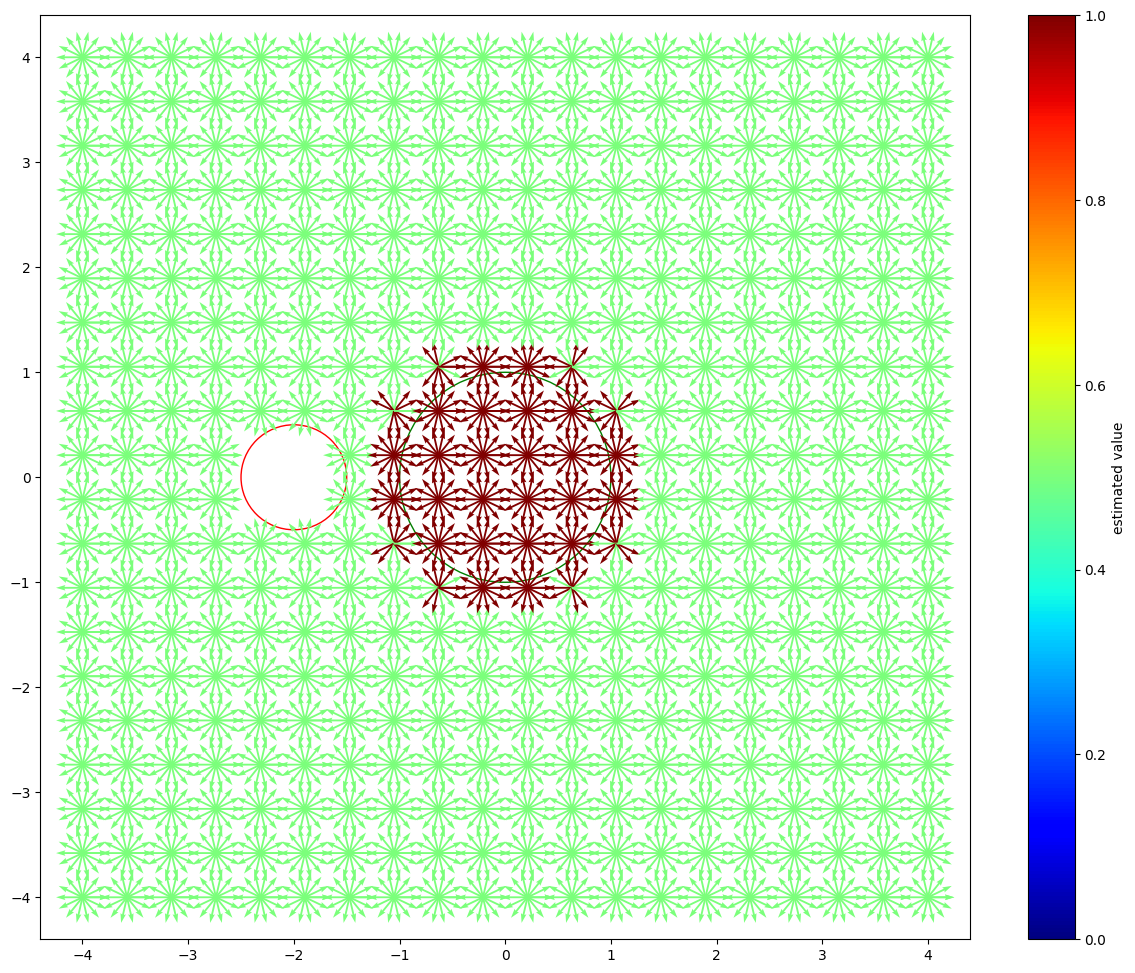

In [34]:
plot_surface(X, env, None, None, ys)

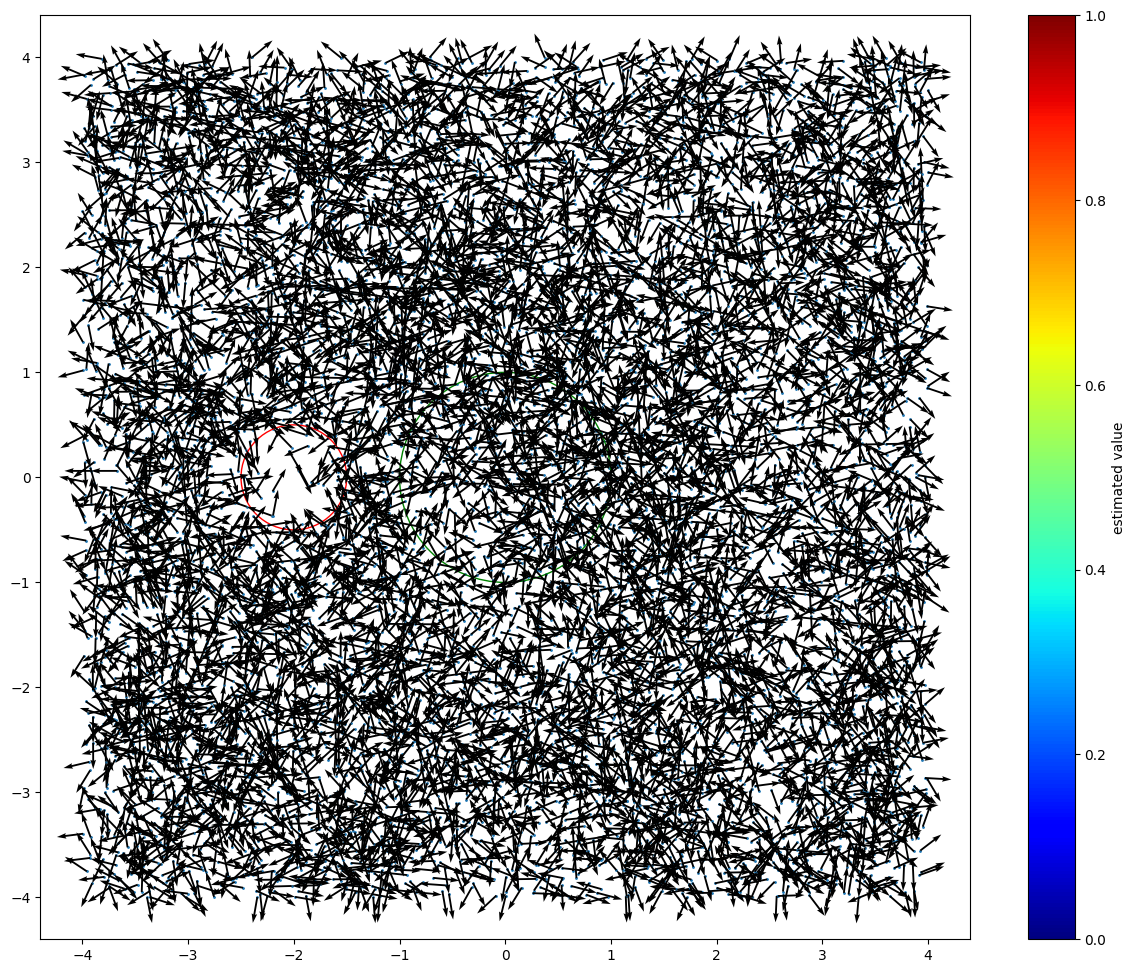

In [35]:
plot_surface(X_val, env, ys=[])

In [36]:
X3 = X.copy()
X_val3 = X_val.copy()
X = np.array(list(map(lambda row: (row[0], row[1], np.cos(row[2]), np.sin(row[2])), X)))
X_val = np.array(list(map(lambda row: (row[0], row[1], np.cos(row[2]), np.sin(row[2])), X_val)))




In [37]:
X

array([[-4.00000000e+00, -4.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [-4.00000000e+00, -4.00000000e+00,  9.00968868e-01,
         4.33883739e-01],
       [-4.00000000e+00, -4.00000000e+00,  6.23489802e-01,
         7.81831482e-01],
       ...,
       [ 4.00000000e+00,  4.00000000e+00,  6.23489802e-01,
        -7.81831482e-01],
       [ 4.00000000e+00,  4.00000000e+00,  9.00968868e-01,
        -4.33883739e-01],
       [ 4.00000000e+00,  4.00000000e+00,  1.00000000e+00,
        -2.44929360e-16]])

In [38]:

def forward(X):
    l1 = hk.Linear(64)(X)
    l2 = jax.nn.relu(l1)
    l3 = hk.Linear(64)(l2)
    l4 = jax.nn.relu(l3)
    l5 = hk.Linear(64)(l4)
    l6 = jax.nn.relu(l5)

    l7= hk.Linear(1)(l6)

    return l7

# a transformed haiku function consists of an 'init' and an 'apply' function
forward = hk.without_apply_rng(hk.transform(forward))



# initialize parameters
rng = jax.random.PRNGKey(seed=14)
params = forward.init(rng, X)

# redefine 'forward' as the 'apply' function
forward = jax.jit(forward.apply)

@jax.jit
def loss_fn(params, X, y):
    err = forward(params, X) - y
    return jnp.mean(jnp.square(err))  # mse




optimizer = optax.adamw(learning_rate=10e-6)
batch_size = 100 #make it 200
losses = [np.inf]
val_losses = [np.inf]
#check we aren't double using gradients
opt_state = optimizer.init(params)
gamma = 0.5

@jax.jit
def train_step(params, X_batch, y_batch, opt_state):
    loss, grads = jax.value_and_grad(loss_fn)(params, X=X_batch, y=y_batch)
    #updates, opt_state = optimizer.update(grads, opt_state)
    updates, opt_state = optimizer.update(grads,params=params, state= opt_state)

    params = optax.apply_updates(params, updates)
    return loss, params, opt_state

FIRST = True

for epoch in range(500):
    epoch_loss = 0.0
    opt_state = optimizer.init(params)
    for batch in range(0, len(X), batch_size):
        X_batch = X[batch:batch+batch_size]


        if FIRST:
            y_batch = ys[batch:batch+batch_size]
            #print(np.unique(y_batch, return_counts=True))
        else:
            y_batch = env.sample_value_iter(X_batch, forward, params, gamma=gamma)
        loss, params, opt_state = train_step(params, X_batch, y_batch, opt_state)
        epoch_loss += loss
    FIRST = False
    epoch_loss /= (len(X) // batch_size)

    # y_val = env.sample_value_iter(X_val, forward, params, gamma=gamma)

    # val_loss = loss_fn(params, X_val, y_val)
    # print("val_loss", val_loss, 'delta' , np.abs(val_loss - val_losses[-1]))
    # if val_losses[-1] - val_loss < 0.0001:
    #     print("early stopping",val_losses[-1] - val_loss)
    #     break
    # val_losses.append(val_loss)


    print('epoch', epoch, 'average loss', epoch_loss, 'epoch delta', np.abs(epoch_loss - losses[-1]))
    losses.append(epoch_loss)

#todo impolement val set for early stopping


epoch 0 average loss 0.49879673 epoch delta inf
epoch 1 average loss 0.23242694 epoch delta 0.2663698
epoch 2 average loss 0.21273643 epoch delta 0.019690514
epoch 3 average loss 0.1946917 epoch delta 0.018044725
epoch 4 average loss 0.1781749 epoch delta 0.016516805
epoch 5 average loss 0.16310191 epoch delta 0.0150729865
epoch 6 average loss 0.14934474 epoch delta 0.013757169
epoch 7 average loss 0.13683474 epoch delta 0.012510002
epoch 8 average loss 0.12554044 epoch delta 0.011294305
epoch 9 average loss 0.1154138 epoch delta 0.010126635
epoch 10 average loss 0.10640782 epoch delta 0.009005979
epoch 11 average loss 0.098474525 epoch delta 0.007933296
epoch 12 average loss 0.09154524 epoch delta 0.006929286
epoch 13 average loss 0.085559525 epoch delta 0.0059857145
epoch 14 average loss 0.0804417 epoch delta 0.005117826
epoch 15 average loss 0.07613271 epoch delta 0.004308991
epoch 16 average loss 0.07256239 epoch delta 0.0035703182
epoch 17 average loss 0.06966191 epoch delta 0.002

KeyboardInterrupt: 

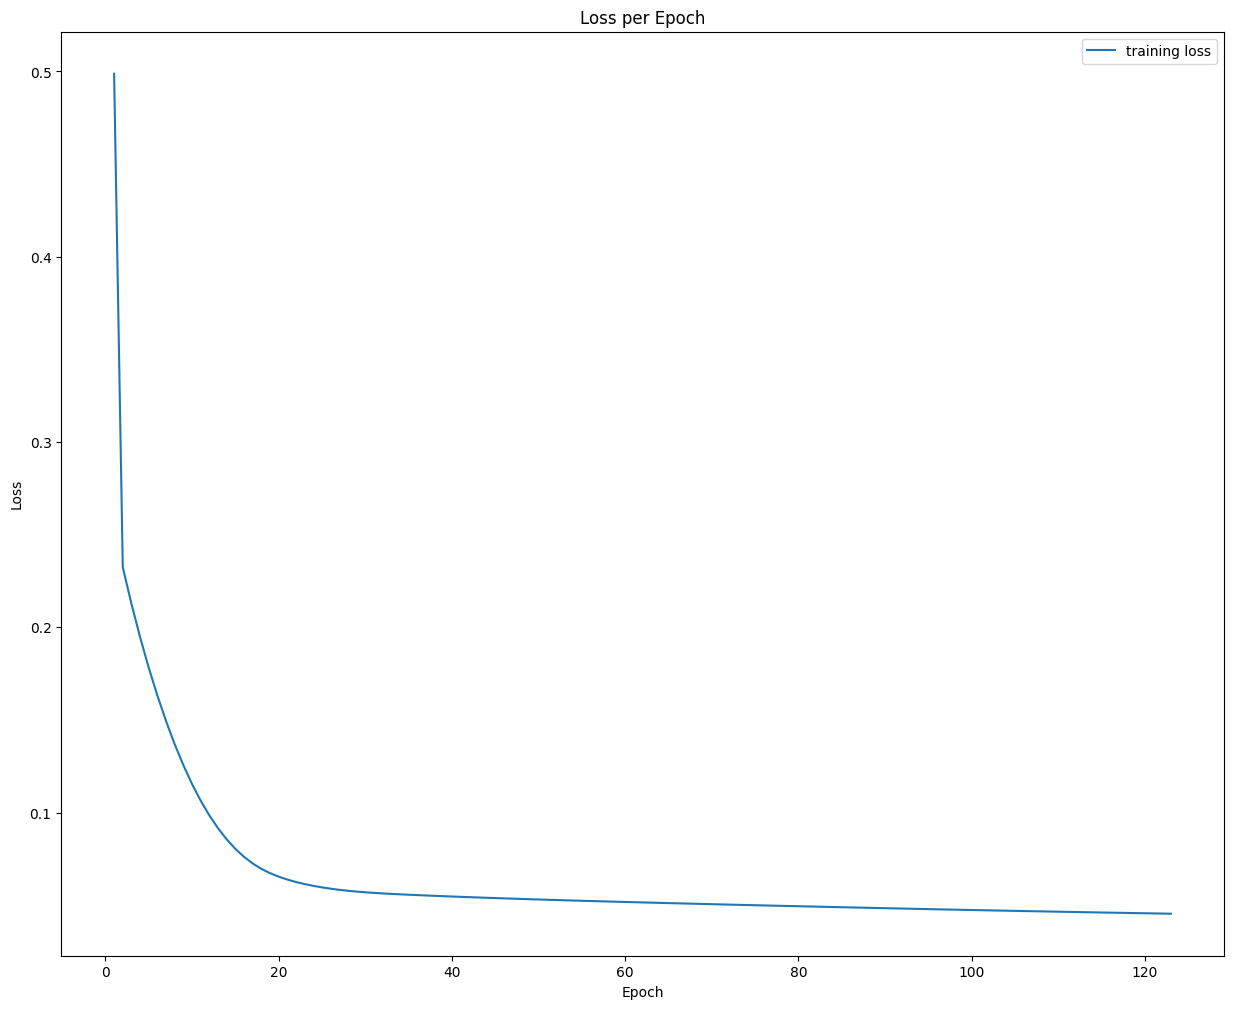

In [39]:
# Plot the losses
%matplotlib inline

lo = [l for l in losses]
#vlo = [l for l in val_losses]


plt.plot(lo, label='training loss')
#plt.plot(vlo, label='validation loss')

# Add a title and labels to the x and y axis
plt.legend()
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Show the plot
plt.savefig('losses_3.png')

plt.show()

In [40]:
#generate data

x_s = np.linspace(-5,5, 20)
y_s = np.linspace(-5,5, 20)
theta_s = np.linspace(0,2*np.pi, 15)

xx, yy, tt = np.meshgrid(x_s, y_s, theta_s)
grid_test = np.vstack([xx.ravel(), yy.ravel(), tt.ravel()]).T



env = DubinsCarEnv()
state = env.reset()
X_test = []
for i in range(len(grid_test)):
    state = env.set(grid_test[i][0], grid_test[i][1], grid_test[i][2])
    X_test.append(state)

X_test = np.array(X_test)

X_test_encoded = np.array(list(map(lambda row: (row[0], row[1], np.cos(row[2]), np.sin(row[2])), X_test)))
X_test_encoded

array([[-5.00000000e+00, -5.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [-5.00000000e+00, -5.00000000e+00,  9.00968868e-01,
         4.33883739e-01],
       [-5.00000000e+00, -5.00000000e+00,  6.23489802e-01,
         7.81831482e-01],
       ...,
       [ 5.00000000e+00,  5.00000000e+00,  6.23489802e-01,
        -7.81831482e-01],
       [ 5.00000000e+00,  5.00000000e+00,  9.00968868e-01,
        -4.33883739e-01],
       [ 5.00000000e+00,  5.00000000e+00,  1.00000000e+00,
        -2.44929360e-16]])

In [41]:



y_pred = [forward(X=x, params=params) for x in X_test_encoded]

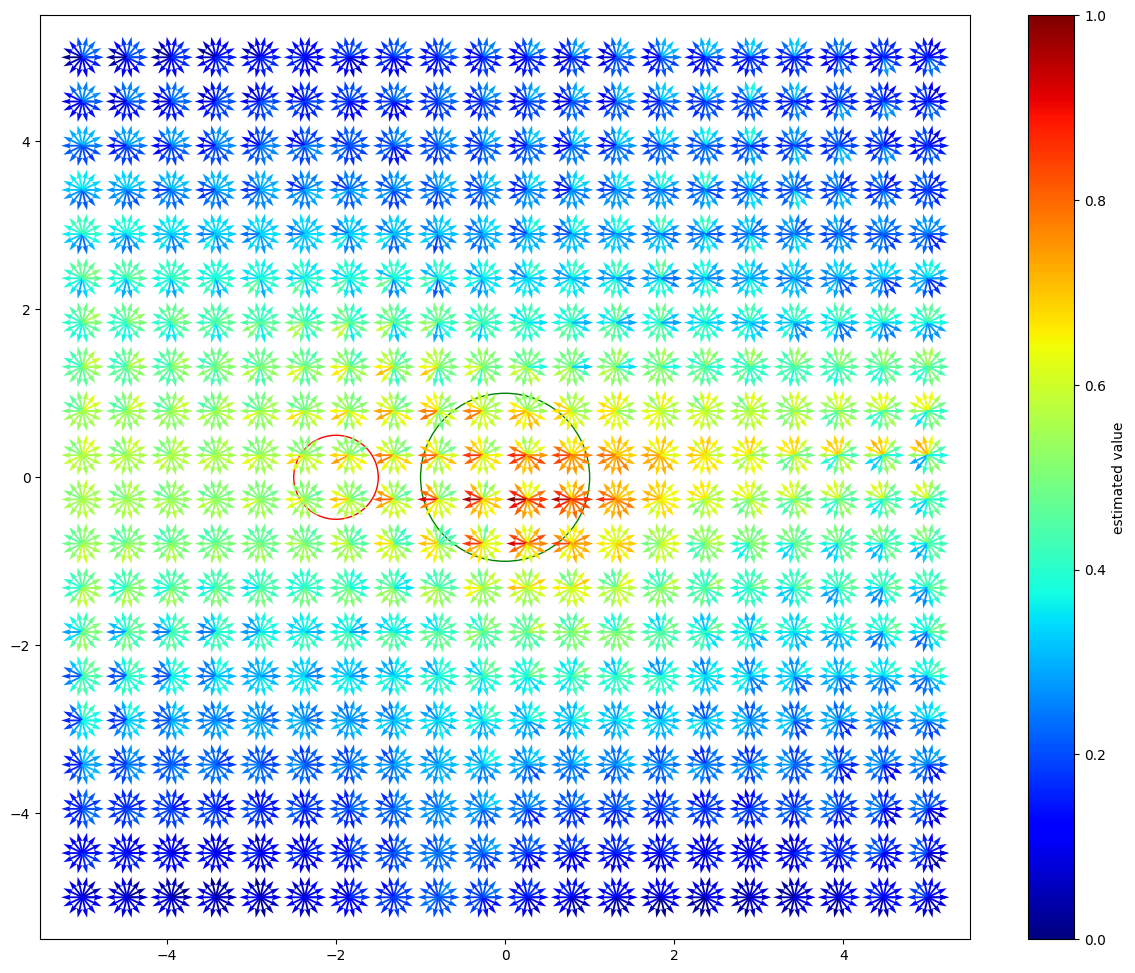

In [42]:
plot_surface(X_test, env, 'experiment.png', y_pred)

In [43]:
y_train = [forward(X=x, params=params) for x in X]

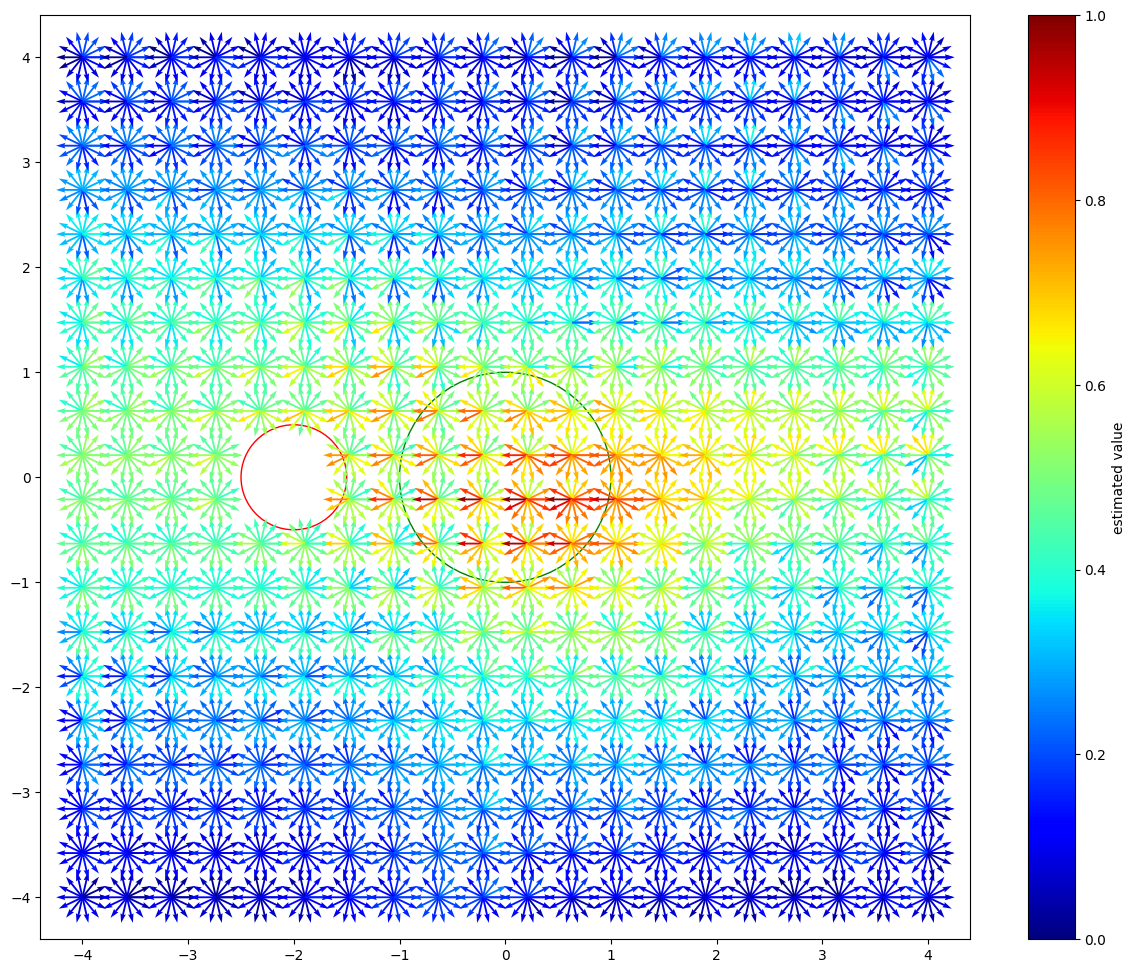

In [44]:
plot_surface(X3, env, 'experiment.png', y_train)

In [45]:
#train on small steps, run on bigger steps?
right = 0
up = np.pi / 2
down = 3 * np.pi / 2
left = np.pi

env = DubinsCarEnv()
state = env.set(-3.9,0, right)
#state = env.reset()

gamma = gamma
traj = []
done = False
max_iter = 50
counter = 0
while (not done) and (counter < max_iter):
    counter+=1
    possible_actions = []
    for a in range(env.action_space.n):
        next_state, reward, done, info = env.step(state, a, update_env=False)


        if info['is_legal']:
            estimate = forward(X=np.array([next_state[0], next_state[1], np.cos(next_state[2]), np.sin(next_state[2])]), params=params)
            value = reward + gamma*estimate[0]
            possible_actions.append(value)
        else:
            possible_actions.append(-np.inf)

    print(possible_actions)
    action = np.argmax(np.array(possible_actions))
    traj.append(state)
    state, reward, done, _ = env.step(action=action, update_env=True)
    env.render()
    print(counter)
    
    
env.make_gif()

[Array(0.09947579, dtype=float32), Array(0.09864804, dtype=float32), Array(0.10442825, dtype=float32), -inf]
1
[Array(0.09916182, dtype=float32), Array(0.10157436, dtype=float32), Array(0.0821164, dtype=float32), Array(0.09584483, dtype=float32)]
2
[Array(0.09803223, dtype=float32), Array(0.0961887, dtype=float32), Array(0.07967315, dtype=float32), Array(0.0964282, dtype=float32)]
3
[Array(0.09852133, dtype=float32), Array(0.09867308, dtype=float32), Array(0.09349217, dtype=float32), Array(0.09081531, dtype=float32)]
4
[Array(0.10034494, dtype=float32), Array(0.09860026, dtype=float32), Array(0.09115127, dtype=float32), Array(0.09238904, dtype=float32)]
5
[Array(0.10375042, dtype=float32), Array(0.10064338, dtype=float32), Array(0.09754933, dtype=float32), Array(0.08474574, dtype=float32)]
6
[Array(0.08932266, dtype=float32), Array(0.09633332, dtype=float32), Array(0.09782933, dtype=float32), Array(0.09882533, dtype=float32)]
7
[Array(0.10419233, dtype=float32), Array(0.0998888, dtype=

In [ ]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
t = np.array([traj])
yp = [forward(X=x, params=params) for x in t]

# Plot...
plt.scatter(np.array(traj)[:,0], np.array(traj)[:,1], c=yp, s=1) # s is a size of marker 
plt.jet()
plt.colorbar()
plt.show()
#plt.savefig('500_iter.png')

ValueError: 'linear/w' with retrieved shape (4, 12) does not match shape=[3, 12] dtype=dtype('float32')

In [ ]:
10*estimate

Array([-31.93895], dtype=float32)

: 

In [ ]:
possible_actions

[Array(-12.71481, dtype=float32),
 Array(-12.356915, dtype=float32),
 Array(-12.71481, dtype=float32)]

: 

In [ ]:
np.argmax(possible_actions)

1

: 

In [ ]:
forward(X=np.array([-4,-4,1, 1]), params=params) 

Array([1.237214], dtype=float32)

In [ ]:
forward(X=np.array([0,0,1, 0]), params=params) 

Array([0.08173393], dtype=float32)

In [ ]:
env.step(np.array([0,0,np.pi]), 0, update_env=False)

(array([2.50000000e-01, 4.37113883e-08, 2.00712864e+00]), 100, True, {})

In [ ]:
X[0]

array([ 1.8830727 , -1.7482759 ,  0.23815954, -0.97122604], dtype=float32)